# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

### Скачаем и изучим данные для проекта.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


### Обработка пропущенных значений
Посмотрим сколько пропущенных значений.

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Больше всего пропущенных значений в столбце "NotRepaired". Скорее всего он не заполнялся, когда машина не была в ремонте, т.е. можно заменить значения на "__no__".

In [6]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

Посмотрим на значения столбца "FuelType".

In [7]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Значение "petrol" и "gasoline" - это одно и то же, так называют бензин в Великобритании и в США, так что можно заменить "gasoline" на "petrol". А поскольку подавляющее число значений столбца - это "petrol" (остальные значения лишь 2% от всех), да и обычно топливом по умолчанию у автомобиля является бензин, если не указывается другое топливо, то пропущенные значения тоже можно заменить на "petrol".

In [8]:
df['FuelType'] = df['FuelType'].fillna('petrol').replace(to_replace ="gasoline",
                                                            value ="petrol")

In [9]:
df['Gearbox'].unique()
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Значений столбца 'Gearbox' только 2: ручная коробка передач и автоматическая (без вариаций автоматической коробки, что может сказываться на значение цены в разную сторону). Обычно машины с автоматической коробкой передач стоят дороже, и это подается как преимущество, следовательно, если не указано, что коробка автоматическая - то скорее всего она механическая и мы можем заполнить пропущенные значения на "manual".

In [10]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

In [11]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox                  0
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
NotRepaired              0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Остается 2 колонки с пропусками. В большинстве случаев тип кузова однозначно определяется моделью автомобиля (кроме случаев исполнения одной модели в кузове "уневерсал" и "седан" или "кабриолет" и "не кабриолет"), так что у этих признаков достаточно высокая коррелляция и можно не использовать признак "VehicleType" для обучения модели. 

А вот пропуски в модели автомобиля могут быть критичны, так что придется от них избавится.

In [12]:
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [13]:
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [14]:
df.dropna(subset = ['Model'], inplace=True)

In [15]:
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          334664 non-null object
Price                334664 non-null int64
VehicleType          304002 non-null object
RegistrationYear     334664 non-null int64
Gearbox              334664 non-null object
Power                334664 non-null int64
Model                334664 non-null object
Kilometer            334664 non-null int64
RegistrationMonth    334664 non-null int64
FuelType             334664 non-null object
Brand                334664 non-null object
NotRepaired          334664 non-null object
DateCreated          334664 non-null object
NumberOfPictures     334664 non-null int64
PostalCode           334664 non-null int64
LastSeen             334664 non-null object
dtypes: int64(7), object(9)
memory usage: 43.4+ MB


### Подготовка датасетов для обучения моделей

Подготовим данные с признаками и целевым признаком. 
Исключим из датасета признаки не влияющие на цену:
- __DateCrawled__ - не должна влиять на цену;
- __RegistrationMonth__ - обычно на цену влияет год выпуска автомобиля, и неважно какой месяц;
- __Brand__ - производители автомобилей стараются не называть модели машин одинаково с конкурентами, поэтому информация о бренде будет лишней (по марке можно определить бренд);
- __NumberOfPictures__ - количество фотографий тоже не может повлиять на цену;
- __DateCreated__ - не должна влиять на цену;
- __PostalCode__ - не должен влиять на цену; 
- __LastSeen__ - не должна влиять на цену;
- __VehicleType__ - коррелируется с "Model";

In [16]:
target = df['Price']
features = df.drop(['DateCrawled', 'VehicleType', 'Price', 'RegistrationMonth', 'Brand', 'NumberOfPictures', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

Разделим датасет на обучающую и валидационную выборку.

In [17]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                    test_size=0.25, 
                                                    random_state=12345)

Для моделей, не умеющих работать с категориальными признаками, закодируем их техникой прямого кодирования One-Hot Encoding

In [18]:
features_ohe = pd.get_dummies(features, columns=['Gearbox', 'Model', 'FuelType', 'NotRepaired'], drop_first=True)

In [19]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, target, 
                                                    test_size=0.25, 
                                                    random_state=12345)

In [20]:
encoder = OrdinalEncoder()
features_oe = features
features_oe[['Gearbox', 'Model', 'FuelType', 'NotRepaired']] = encoder.fit_transform(features_oe[['Gearbox', 'Model', 'FuelType', 'NotRepaired']])

In [21]:
features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(features_oe, target, 
                                                    test_size=0.25, 
                                                    random_state=12345)

Теперь данные для обучения и проверки моделей готовы.

## Обучение моделей

### LinearRegression (обученная на данных, закодированных One-Hot Encoding)
Обучим модель __LinearRegression__ на закодированных техникой One-Hot Encoding данных.

In [22]:
%%time
model1 = LinearRegression().fit(features_train_ohe, target_train_ohe)

CPU times: user 12.6 s, sys: 4.34 s, total: 16.9 s
Wall time: 17 s


In [23]:
%%time
predicted_valid1 = model1.predict(features_valid_ohe)

CPU times: user 87.5 ms, sys: 127 ms, total: 215 ms
Wall time: 197 ms


In [24]:
rmse1 = mean_squared_error(target_valid_ohe, predicted_valid1)** 0.5
rmse1

3385.1857516647947

### LinearRegression (обученная на данных, закодированных OrdinalEncoder)

In [25]:
%%time
model_lroe = LinearRegression().fit(features_train_oe, target_train_oe)

CPU times: user 58.8 ms, sys: 11.5 ms, total: 70.3 ms
Wall time: 51.5 ms


In [26]:
%%time
predicted_valid_lroe = model_lroe.predict(features_valid_oe)

CPU times: user 44.6 ms, sys: 64.9 ms, total: 109 ms
Wall time: 141 ms


In [28]:
rmse_lroe = mean_squared_error(target_valid_oe, predicted_valid_lroe)** 0.5
rmse_lroe

3961.348425836942

### LightGBM

Для обучения модели LightGBM, поменяем тип данных в категориальных признаках на "category" и создадим список м категориальными признаками.

In [29]:
cat = ['Gearbox', 'Model', 'FuelType', 'NotRepaired']

In [30]:
features_train_lgbm = features_train.astype({"Gearbox":'category',
                                              "Model":'category',
                                              "FuelType":'category',
                                              "NotRepaired":'category'})
features_valid_lgbm = features_valid.astype({"Gearbox":'category',
                                              "Model":'category',
                                              "FuelType":'category',
                                              "NotRepaired":'category'})

Посмотрим какие значения гиперпараметров "n_estimators" и "max_depth" дают наилучшие показатели RMSE.

Чтобы не загружать проверку ноутбука, ячейки с циклами подбора параметров переведены в RAW, а таблицы с результатами приведены ниже:

| | n_estimators	| rmse2 |
    :--- | :---: | ---:
0	|1.0	|4221.703170
1	|101.0	|1836.463512
2	|201.0	|1802.282724
3	|301.0	|1787.042767
4	|401.0	|1776.301612
5	|501.0	|1769.355737
6	|601.0	|1764.183064
7	|701.0	|1758.965180
8	|801.0	|1754.841475
9	|901.0	|1751.997220

| | max_depth	| rmse2|
   :--- | :---: | ---:
0	|5.0	|1791.105741
1	|6.0	|1778.298193
2	|7.0	|1774.185108
3	|8.0	|1775.150595
4	|9.0	|1768.733819
5	|10.0	|1771.625727
6	|11.0	|1770.882966

Лучшее значение RMSE у модели с n_estimators=500 (так как дальше улучшение замедляется) и max_depth=9.

In [31]:
%%time
model_2 = LGBMRegressor(n_estimators=500, max_depth=9).fit(features_train_lgbm, target_train)

CPU times: user 29 s, sys: 156 ms, total: 29.2 s
Wall time: 29.5 s


In [32]:
%%time
predicted_valid2 = model_2.predict(features_valid_lgbm)

CPU times: user 3.16 s, sys: 0 ns, total: 3.16 s
Wall time: 3.12 s


In [33]:
rmse2 = mean_squared_error(target_valid, predicted_valid2)** 0.5
rmse2

1768.7237509057009

### CatBoost

Выберем глубину 11.

| |max_depth |	rmse3|
 :--- | :---: | ---:
0	|4.0	|1929.262779
1	|5.0	|1896.488973
2	|6.0	|1879.099679
3	|7.0	|1864.012880
4	|8.0	|1851.772123
5	|9.0	|1835.427049
6	|10.0	|1827.760961
7	|11.0	|1821.816377
8	|12.0	|1821.788603
9	|13.0	|1825.858089
10	|14.0	|1817.438618

In [34]:
%%time

model3 = CatBoostRegressor(loss_function="RMSE", iterations=200, learning_rate=0.5, depth=11) 
model3.fit(features_train, target_train, cat_features=cat, verbose=100)

0:	learn: 3110.1773777	total: 816ms	remaining: 2m 42s
100:	learn: 1716.3466012	total: 1m 6s	remaining: 1m 5s
199:	learn: 1633.7374274	total: 2m 12s	remaining: 0us
CPU times: user 1min 56s, sys: 17.7 s, total: 2min 13s
Wall time: 2min 15s


In [35]:
%%time
predicted_valid3 = model3.predict(features_valid)

CPU times: user 486 ms, sys: 32.6 ms, total: 518 ms
Wall time: 509 ms


In [36]:
rmse3 = mean_squared_error(target_valid, predicted_valid3)** 0.5
rmse3

1821.816376656906

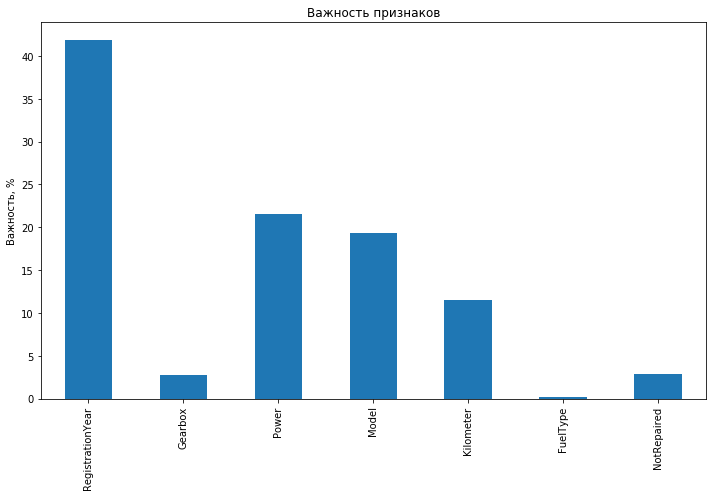

In [37]:
df_imp = pd.Series(model3.get_feature_importance(),
                         features_train.columns)
fig, ax = plt.subplots(figsize=(10,7))
df_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

### DecisionTreeRegressor (обученная на данных, закодированных One-Hot Encoding)

Подберем лучшее значение "max_depth" для модели DecisionTreeRegressor.

	
Чем больше глубина дерева, тем лучше RMSE, но при глубине 17 улучшение замедляется, поэтому остановимся на моделе с глубиной 17.

|    | max_depth	| rmse4|
    :--- | :---: | ---:
0	|9.0	|2189.181049
1	|10.0	|2149.587639
2	|11.0	|2098.186001
4	|13.0	|2080.598942
5	|14.0	|2060.277110
6	|15.0	|2046.224762
7	|16.0	|2041.373652
8	|17.0	|2032.028972
9	|18.0	|2031.759968
10	|19.0	|2031.561979

In [38]:
%%time
model_4 = DecisionTreeRegressor(random_state=12345, max_depth=17)
model_4.fit(features_train_ohe, target_train_ohe)

CPU times: user 6.21 s, sys: 194 ms, total: 6.4 s
Wall time: 6.41 s


DecisionTreeRegressor(criterion='mse', max_depth=17, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [39]:
%%time
predictions_valid4 = model_4.predict(features_valid_ohe)

CPU times: user 47.6 ms, sys: 86.3 ms, total: 134 ms
Wall time: 142 ms


In [40]:
rmse4 = mean_squared_error(target_valid_ohe, predictions_valid4)** 0.5
rmse4

2032.0289718837453

### DecisionTreeRegressor (обученная на данных, закодированных OrdinalEncoder)

In [41]:
%%time
model_dtroe = DecisionTreeRegressor(random_state=12345, max_depth=17)
model_dtroe.fit(features_train_oe, target_train_oe)

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 568 ms


DecisionTreeRegressor(criterion='mse', max_depth=17, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [42]:
%%time
predictions_valid_troe = model_dtroe.predict(features_valid_oe)

CPU times: user 20 ms, sys: 3.48 ms, total: 23.5 ms
Wall time: 22.1 ms


In [43]:
rmse_dtroe= mean_squared_error(target_valid_oe, predictions_valid_troe)** 0.5
rmse_dtroe

2074.1770777817214

## Анализ моделей

Соберем полученные данные в итоговую таблицу.

In [44]:
data = [["23.9 s", "208 ms", 3385.18],
        ["34.8 ms", "2.7 ms", 3961.34],
        ["41.4 s", "6.17 s", 1768.72],
        ["3min 5s", "691 ms", 1821.81],
        ["7.43 s", "159 ms", 2032.02],
        ["511 ms", "18.9 ms", 2074.17]]
model = ["LinearRegression (OHE)", "LinearRegression (OE)", "LGBM", "CatBoost", "DecisionTreeRegressor (OHE)", "DecisionTreeRegressor (OE)"]

In [45]:
pd.DataFrame(data=data, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
LinearRegression (OHE),23.9 s,208 ms,3385.18
LinearRegression (OE),34.8 ms,2.7 ms,3961.34
LGBM,41.4 s,6.17 s,1768.72
CatBoost,3min 5s,691 ms,1821.81
DecisionTreeRegressor (OHE),7.43 s,159 ms,2032.02
DecisionTreeRegressor (OE),511 ms,18.9 ms,2074.17


## Выводы

В ходе выполнения проекта необходимо было построить модель для определения стоимости автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

Имеющиеся исторические данные: технические характеристики, комплектации и цены автомобилей, были подготовлены для обучения и анализа моделей.

Были выбраны 4 модели регрессии: LinearRegression, LGBM, CatBoost и DecisionTreeRegressor. Время обучения, предсказания и метрика RMSE для каждой модели собраны в итоговую таблицу.


| |fit_time |predict_time |	RMSE |
 :--- | :---:| :---: | ---:
__LinearRegression (OHE)__	|23.9 s	|208 ms	|3385.18
__LinearRegression (OE)__	|34.8 ms	|2.7 ms	|3961.34
__LGBM__	|41.4 s	|6.17 s	|1768.72
__CatBoost__	|3min 5s	|691 ms	|1821.81
__DecisionTreeRegressor (OHE)__	|7.43 s	|159 ms	|2032.02
__DecisionTreeRegressor (OE)__	|511 ms	|18.9 ms	|2074.17

Самой лучшей метрики RMSE удалось добиться у модели LGBM, но у нее самое большое время предсказания, что критично для приложения, которое хочет привлечь новых клиентов. Вторым по RMSE идет модель CatBoost, но у нее очень большое время обучения. 

Самой оптимальной моделью является DecisionTreeRegressor, у которой не слишком сильно хуже RMSE, но зато самые быстрые обучение и предсказание.

При кодирование категориальных переменных техникой Ordinal Encoding - RMSE получается немного хуже, чем при кодировании One-Hot Encoding, но зато скорость обучения модели и предсказания увеличиваются на порядок.